In [1]:
import pandas as pd
from compressor import (IntelligentCompressor, KMeansClustering, HierarchicalClustering, DBSCANClustering, \
    # Word2VecEmbedding,
                        HDBSCANClustering, BIRCHClustering, OPTICSClustering, GMMClustering, MeanShiftClustering, \
    AffinityPropagationClustering, SpectralClusteringMethod)
from pathlib import Path
from reader import FastqProcessor, SequenceMatch
from HeatMapVis import SequenceVisualizer
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from Bio import SeqIO
from fuzzy_searcher import FuzzySearcher
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Embeddings import (Word2VecEmbedding,
                        WeightedWord2VecEmbedding,
                        PositionalEncodingWord2VecEmbedding,
                        Bio2VecEmbedding,
                        LSTMEmbedding,
                        TransformerSequenceEmbedding)

In [2]:
def reverse_complement(seq: str) -> str:
    """Generate reverse complement of a DNA sequence."""
    complement = str.maketrans("ATGC", "TACG")
    return seq.translate(complement)[::-1]

def record_reverse_complement(record: SeqRecord) -> SeqRecord:
    """
    Return a new SeqRecord with the reverse complement of the given sequence.
    """
    return SeqRecord(
        seq=record.seq.reverse_complement(),
        id=record.id + "_RC",
        description=record.description + " reverse complement",
        letter_annotations=record.letter_annotations
    )

In [3]:
fastq_file = Path("/Users/maria/PycharmProjects/oxo_dG/input_files/2026_cassette/fastq/calls.covers44_109.span.bc23.fastq")

In [1]:
query_dict = {
    "A1": "GATCAGTCCGATATC",
    "A2": "TCGACATGCTAGTGC",
    "A3": "GCTATCGGATACGTC",
    "S1_L_S2": "ATGACTGCCATTTTTTTGGCAGTCAT",
    "A1C": "GACGTATCCGATAGC",
    "A2C": "GCACTAGCATGTCGA",
    "A3C": "GATATCGGACTGATC"
}

In [5]:
#processor = FastqProcessor(fastq_file, query_dict, 1.0)
processor = FuzzySearcher(
    fastq_path=fastq_file,
    query_dict=query_dict,
    output_parquet=Path("matches.parquet"),
    similarity_threshold=0.9
)

In [6]:
sequence_matches = processor.search()

Scanning FASTQ: 1457964it [01:42, 14156.96it/s]

✅ Finished. Parquet saved to: matches.parquet


In [1]:
import pyarrow.parquet as pq


In [2]:
matches_parquet = "matches.parquet"

In [2]:
table = pq.read_table(matches_parquet)


NameError: name 'pq' is not defined

In [4]:
table.schema

seq_id: string
query_name: string
position: int32
length: int16
score: float

In [5]:
table.num_rows

8663401

In [6]:
table.slice(0, 10).to_pandas()

,seq_id,query_name,position,length,score
0,5284e66b-b7b4-44db-9949-f73969d28dbd,A2,27,14,1.000000
1,5284e66b-b7b4-44db-9949-f73969d28dbd,A3,51,14,1.000000
2,5284e66b-b7b4-44db-9949-f73969d28dbd,S1_L_S2,66,25,1.000000
3,5284e66b-b7b4-44db-9949-f73969d28dbd,A1C,92,14,1.000000
4,5284e66b-b7b4-44db-9949-f73969d28dbd,A2C,116,14,1.000000
5,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A1,0,14,1.000000
6,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A3,48,14,1.000000
7,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A1C,86,14,1.000000
8,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A2C,110,13,0.933333
9,e61c5274-61c0-4546-b0fe-c139b4881cb6,A1,0,14,1.000000


In [12]:
!pip install duckdb

zsh:1: command not found: pip


In [3]:
import duckdb

In [8]:
df = duckdb.query("""
SELECT *
FROM 'matches.parquet'
LIMIT 10
""").to_df()

In [9]:
df.head(100)

,seq_id,query_name,position,length,score
0,5284e66b-b7b4-44db-9949-f73969d28dbd,A2,27,14,1.000000
1,5284e66b-b7b4-44db-9949-f73969d28dbd,A3,51,14,1.000000
2,5284e66b-b7b4-44db-9949-f73969d28dbd,S1_L_S2,66,25,1.000000
3,5284e66b-b7b4-44db-9949-f73969d28dbd,A1C,92,14,1.000000
4,5284e66b-b7b4-44db-9949-f73969d28dbd,A2C,116,14,1.000000
5,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A1,0,14,1.000000
6,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A3,48,14,1.000000
7,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A1C,86,14,1.000000
8,b6afcfc1-adfe-4ff3-af82-e4f82ae27091,A2C,110,13,0.933333
9,e61c5274-61c0-4546-b0fe-c139b4881cb6,A1,0,14,1.000000


In [10]:
duckdb.query("""
SELECT query_name,
        round(avg(position)) as average_potision,
        median(position),
        min(position),
        max(position),
        stddev(position),
        count(*)
FROM 'matches.parquet' 
GROUP BY query_name
""").show()

┌────────────┬──────────────────┬────────────────────┬─────────────────┬─────────────────┬────────────────────┬──────────────┐
│ query_name │ average_potision │ median("position") │ min("position") │ max("position") │ stddev("position") │ count_star() │
│  varchar   │      double      │       double       │      int32      │      int32      │       double       │    int64     │
├────────────┼──────────────────┼────────────────────┼─────────────────┼─────────────────┼────────────────────┼──────────────┤
│ A1         │              3.0 │                0.0 │               0 │          146839 │ 169.27809787987763 │      1301071 │
│ A2         │             27.0 │               24.0 │               0 │          146863 │ 163.36374079357668 │      1374572 │
│ A2C        │            114.0 │              112.0 │               0 │          146950 │ 180.77520933323757 │      1134225 │
│ A3C        │            138.0 │              136.0 │               0 │          146974 │ 196.50248224333808 │

In [4]:
from StreamingEmbedding import Word2VecStreamingEmbedding, DirectEmbedding

In [5]:
embedder = DirectEmbedding()

embedder.train(matches_parquet)

Found 7 unique query_names: ['A1', 'A1C', 'A2', 'A2C', 'A3', 'A3C', 'S1_L_S2']


In [6]:
embedder.embed_to_parquet(
    parquet_path=matches_parquet,
    output_path="embeddings.parquet"
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Embeddings saved to embeddings.parquet
Shape: (1457932, 8)
Columns: ['seq_id', 'A1', 'A1C', 'A2', 'A2C', 'A3', 'A3C', 'S1_L_S2']


,seq_id,A1,A1C,A2,A2C,A3,A3C,S1_L_S2
0,00000169-4666-4d24-a87b-fc1f9259baa9,0,89,24,113,48,138,63
1,00000235-98bf-471e-8fbd-179cdd9a9bb0,0,87,24,0,46,131,61
2,000009a0-f811-4f92-84bb-ae664de66532,0,0,24,0,48,123,0
3,0000160a-55e0-4427-b79b-cc9eab18a054,0,86,21,110,45,0,60
4,000026a0-8683-4902-b139-198b86b5df67,0,89,24,113,48,137,63
...,...,...,...,...,...,...,...,...
1457927,ffffbe56-6103-4fe3-8acf-ad89cc764b47,0,89,24,0,48,139,63
1457928,ffffbe7d-ea29-42bc-a871-5d7252391a60,0,91,24,115,49,139,64
1457929,ffffee68-184c-43de-b57e-bf4c14d36101,0,74,0,0,46,0,0
1457930,fffff0ce-eb17-4b7d-abb1-6139a8d10bf9,0,89,24,113,48,0,63


In [12]:
df_emb = duckdb.query("""
SELECT *
FROM 'embeddings.parquet'
""").to_df()

In [13]:
df_emb.head(10)

,seq_id,A1,A1C,A2,A2C,A3,A3C,S1_L_S2
0,00000169-4666-4d24-a87b-fc1f9259baa9,0,89,24,113,48,138,63
1,00000235-98bf-471e-8fbd-179cdd9a9bb0,0,87,24,0,46,131,61
2,000009a0-f811-4f92-84bb-ae664de66532,0,0,24,0,48,123,0
3,0000160a-55e0-4427-b79b-cc9eab18a054,0,86,21,110,45,0,60
4,000026a0-8683-4902-b139-198b86b5df67,0,89,24,113,48,137,63
5,00002f38-6bd0-45ec-a193-2045a7b22198,0,88,0,0,47,132,62
6,00003732-651a-4cb5-b3b5-de3ce79bd8fa,0,88,26,0,50,133,0
7,0000466d-13a1-441d-bc74-c2315896a652,0,88,24,0,47,139,62
8,00006a83-c731-4bb1-a312-9d27ea25331d,0,89,24,114,48,0,63
9,00006e5d-84c9-48b4-a17a-2313668adf00,0,0,24,111,47,0,62


In [14]:
df_emb.describe().T

,count,mean,std,min,25%,50%,75%,max
A1,1457932.0,1.481852,158.901592,0.0,0.0,0.0,0.0,146839.0
A1C,1457932.0,78.725149,160.697177,0.0,86.0,88.0,89.0,146926.0
A2,1457932.0,22.759165,157.670564,0.0,23.0,24.0,24.0,146863.0
A2C,1457932.0,82.246344,166.875166,0.0,0.0,111.0,113.0,146950.0
A3,1457932.0,46.555470,158.586705,0.0,47.0,48.0,49.0,146887.0
A3C,1457932.0,72.137650,163.414113,0.0,0.0,126.0,136.0,146974.0
S1_L_S2,1457932.0,56.708220,145.127078,0.0,61.0,63.0,63.0,146902.0


In [17]:
import clustering

In [18]:
results, clusterer = clustering.optimized_clustering_pipeline(
        embeddings_path="embeddings.parquet",
        n_clusters=100,  # Количество кластеров
        method='optimized_hierarchical',  # или 'fast_kmeans'
        reduction_size=10000  # Размер репрезентативной выборки
    )

ОПТИМИЗИРОВАННАЯ КЛАСТЕРИЗАЦИЯ

1. ЗАГРУЗКА ДАННЫХ
----------------------------------------
Загрузка embeddings.parquet...
Загружено: 1457932 записей
Признаки: ['A1', 'A1C', 'A2', 'A2C', 'A3', 'A3C', 'S1_L_S2']
Размер в памяти: 38.93 MB

2. НАСТРОЙКА МЕТОДА КЛАСТЕРИЗАЦИИ
----------------------------------------
Метод: OptimizedHierarchical_kmeans
Количество кластеров: 100

3. ПОДГОТОВКА ДАННЫХ
----------------------------------------
Применяем PCA: 7 -> 5
K-means reduction: 1457932 -> 10000
Reduction completed in 61.66 seconds
Репрезентативная выборка: 7293 точек

4. ВЫПОЛНЕНИЕ КЛАСТЕРИЗАЦИИ
----------------------------------------
Medium dataset (7293 samples), using AgglomerativeClustering
Clustering completed in 1.91 seconds

5. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
----------------------------------------
Присваиваем метки остальным точкам...

РЕЗУЛЬТАТЫ СОХРАНЕНЫ:
- Parquet: clustering_results_optimized.parquet
- CSV: clustering_results_optimized.csv

Статистика по кластерам:
cluster
0     19819

In [26]:
df_clust = duckdb.query("""
SELECT *
FROM 'clustering_results_optimized.parquet'
""").to_df()

In [27]:
df_clust.head()

,seq_id,cluster,feature_A1,feature_A1C,feature_A2,feature_A2C,feature_A3,feature_A3C,feature_S1_L_S2
0,00000169-4666-4d24-a87b-fc1f9259baa9,17,0.0,89.0,24.0,113.0,48.0,138.0,63.0
1,00000235-98bf-471e-8fbd-179cdd9a9bb0,61,0.0,87.0,24.0,0.0,46.0,131.0,61.0
2,000009a0-f811-4f92-84bb-ae664de66532,18,0.0,0.0,24.0,0.0,48.0,123.0,0.0
3,0000160a-55e0-4427-b79b-cc9eab18a054,68,0.0,86.0,21.0,110.0,45.0,0.0,60.0
4,000026a0-8683-4902-b139-198b86b5df67,17,0.0,89.0,24.0,113.0,48.0,137.0,63.0


In [25]:
comparison = clustering.compare_methods("embeddings.parquet", n_clusters=100)


ТЕСТИРОВАНИЕ: optimized_hierarchical
Применяем PCA: 7 -> 5
K-means reduction: 1457932 -> 5000
Reduction completed in 27.88 seconds
Small dataset (2650 samples), using classical hierarchical
Clustering completed in 0.16 seconds
Время: 29.52 сек

ТЕСТИРОВАНИЕ: fast_kmeans
Applying PCA: 7 -> 5
Running MiniBatchKMeans with 100 clusters...
KMeans clustering completed in 1.08 seconds
Время: 1.99 сек

ТЕСТИРОВАНИЕ: random_hierarchical
Применяем PCA: 7 -> 5
Random sampling: 1457932 -> 5000
Reduction completed in 0.10 seconds
Small dataset (5000 samples), using classical hierarchical
Clustering completed in 0.70 seconds
Время: 1.64 сек


In [2]:
import visualization

ОПТИМИЗИРОВАННАЯ ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ
Загрузка данных чанками по 100000 записей...


Обработка чанков: 87it [00:44,  1.95it/s]


Загружено 8663401 совпадений
Группировка по кластерам...


Группировка кластеров: 100%|██████████| 100/100 [00:02<00:00, 46.68it/s]


Группировка завершена за 2.42 сек
Сжатие данных методом 'representative'...


Сжатие кластеров: 100%|██████████| 100/100 [00:08<00:00, 11.55it/s]



Подготовлено 100 последовательностей для визуализации


Создание матрицы: 100%|██████████| 100/100 [00:00<00:00, 12865.17it/s]



Query match statistics:
Query A1: 193 matches
Query A2: 211 matches
Query A3: 186 matches
Query S1_L_S2: 170 matches
Query A1C: 170 matches
Query A2C: 192 matches
Query A3C: 200 matches
Размер матрицы: (100, 2039, 2)

График сохранен как cluster_viz_representative.png

Общее время выполнения: 60.25 секунд


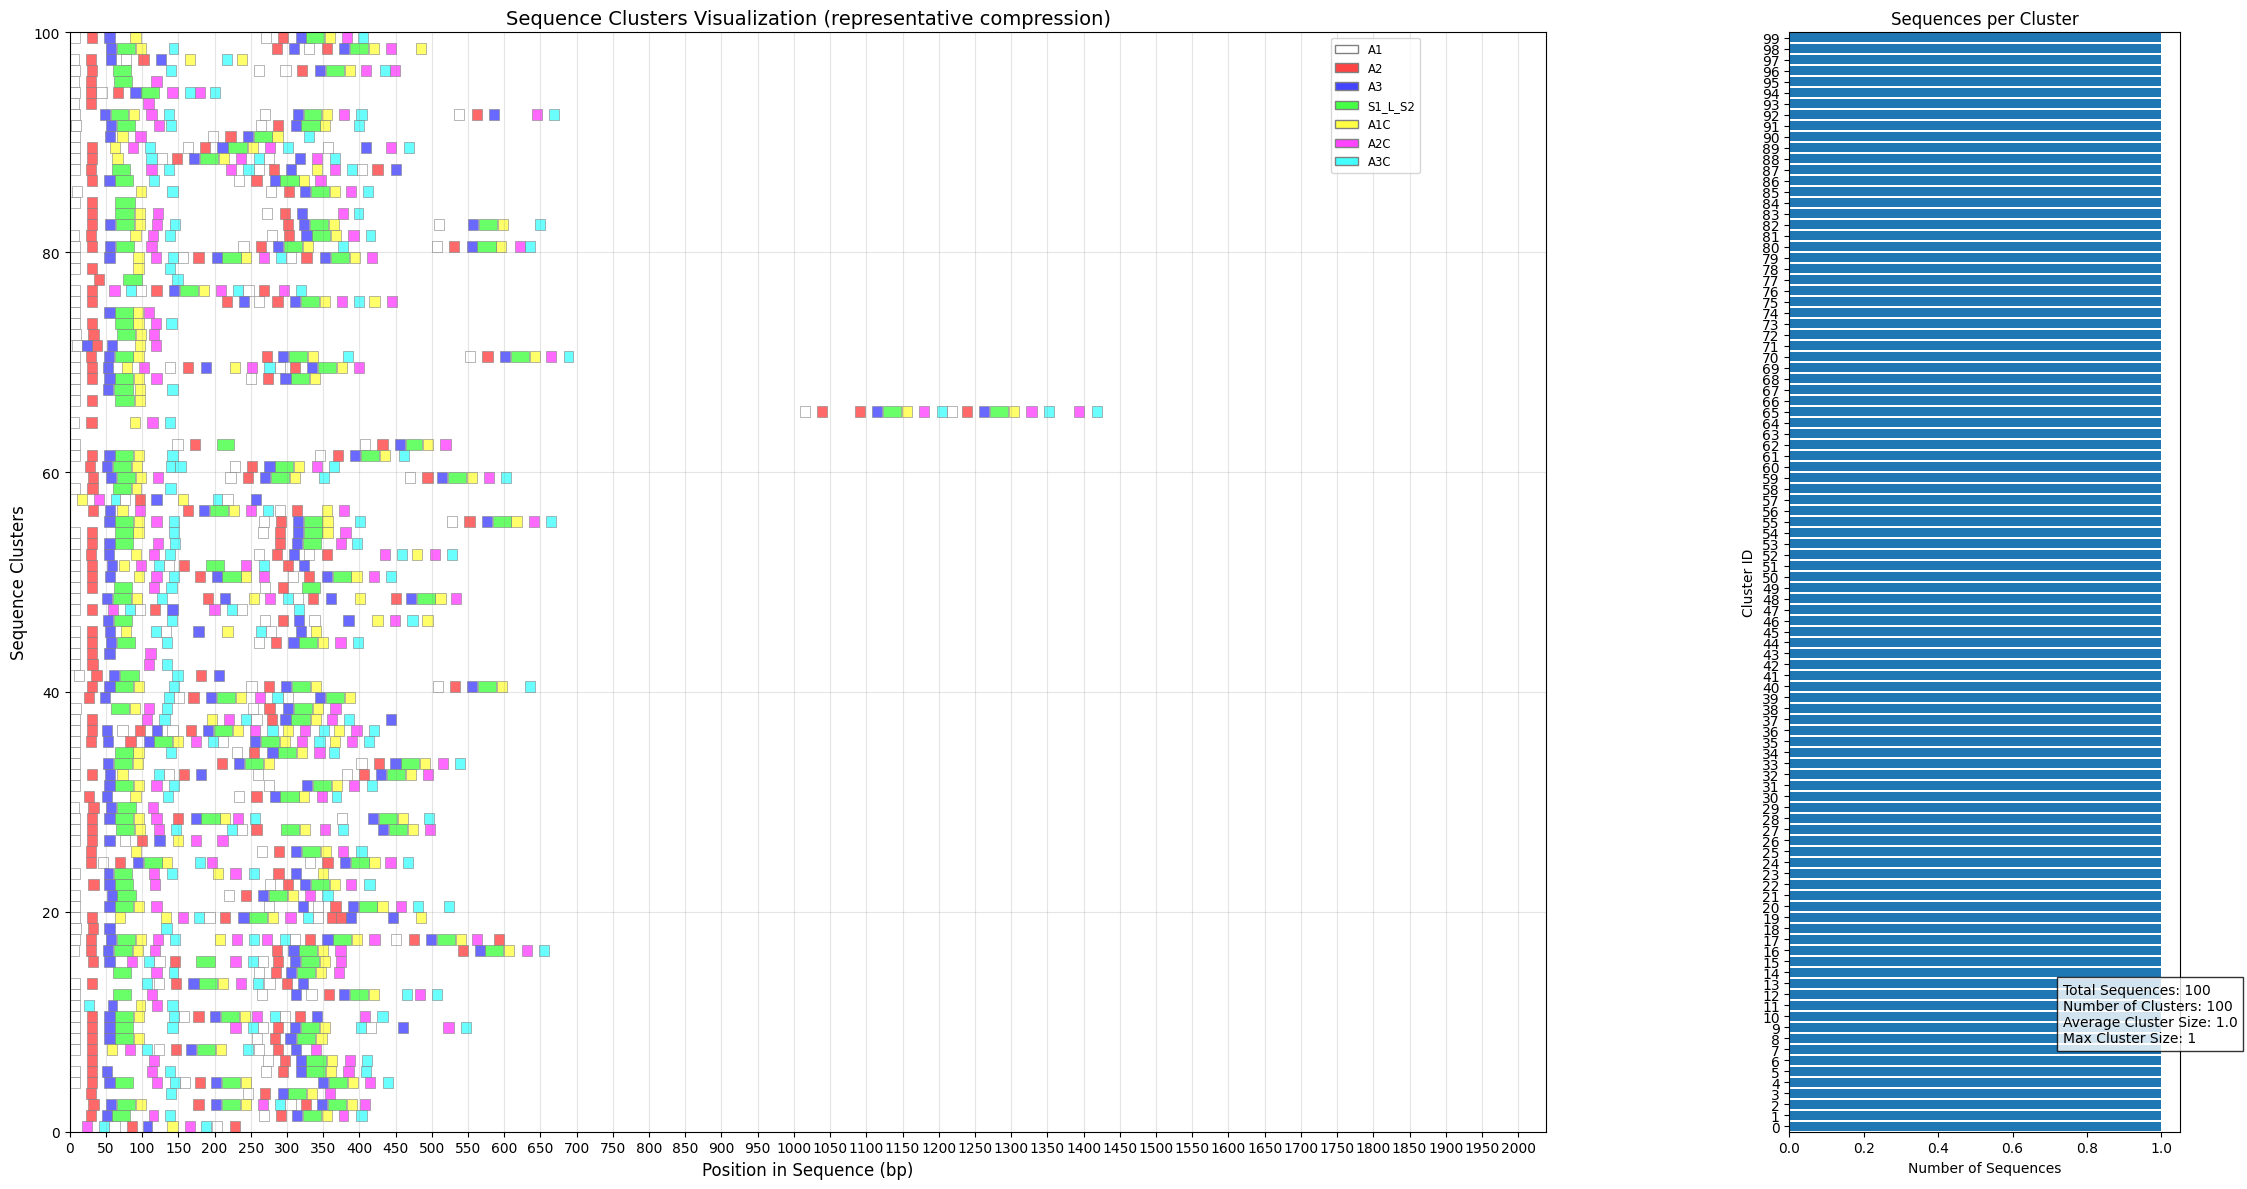

In [3]:
visualization.run_optimized_visualization(
            matches_path="matches.parquet",
            clusters_path="clustering_results_optimized.parquet",
            query_dict=query_dict,
            compression_method='representative',
            max_seq_per_cluster=30, 
            output_image=f'cluster_viz_representative.png'
        )

In [33]:
# Создаем визуализатор
visualizer = SequenceVisualizer(query_dict, target_clusters=100)

In [34]:
# Пути к вашим файлам
matches_path = "matches.parquet"  # файл с совпадениями
clusters_path = "clustering_results_optimized.parquet"  # файл с кластерами

In [35]:
# Подготавливаем данные для визуализации
compressed_matches, cluster_assignments = visualizer.prepare_for_visualization(
    matches_path=matches_path,
    clusters_path=clusters_path,
    compression_method='merge'  # или 'representative' или 'all'
)

Загрузка данных из parquet файлов...
Загружено 8663401 совпадений из matches.parquet
Загружено 1457932 записей о кластерах из clustering_results_optimized.parquet


KeyboardInterrupt: 

In [ ]:
# Создаем визуализационную матрицу
vis_matrix = visualizer.create_visualization_matrix(compressed_matches)

In [ ]:
# Строим тепловую карту
fig = visualizer.plot_heatmap(
    vis_matrix=vis_matrix,
    cluster_assignments=cluster_assignments,
    title='Sequence Clusters Visualization'
)

In [ ]:
# Сохраняем результат
plt.savefig('cluster_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(f"\nВизуализация завершена!")
print(f"Форма матрицы: {vis_matrix.shape}")
print(f"Количество кластеров: {len(np.unique(cluster_assignments))}")